# DLISIO in a Nutshell

## Importing

In [1]:
%matplotlib inline

import os
import pandas as pd
import dlisio
import matplotlib.pyplot as plt
import numpy as np
import numpy.lib.recfunctions as rfn

### You can work with a single file using the cell below - or by adding an additional for loop to the code below, you can work through a list of files.  Another option is to use os.walk to get all .dlis files in a parent folder.  Example:

    for (root, dirs, files) in os.walk(folderpath):
        for f in files:
            filepath = os.path.join(root, f)
            if filepath.endswith('.' + 'dlis'):
                print(filepath)
                
### But for this example, we will work with a single .dlis file specified in the cell below.  Note that there are some .dlis file formats that are not supported by DLISIO yet - good to catch them in a try except loop if you are reading files enmasse.

### Version 0.1.11 introduced the ability to read multple files smashed into one .dlis file.  This example is still looking at a single frame, but I will try to write some more cohesive examples after summer for bulk work.

### We will load a file from the open source Volve dataset available here: https://data.equinor.com/dataset/Volve

In [2]:
filepath = r"C:\Users\aruss\OneDrive - Equinor\Desktop_2019\Volve_Well_logs_pr_WELL\15_9-F-4\02.LWD_EWL\WL_RAW_CAL-DEN-GR-NEU-REMP_MWD_1.DLIS"

## Reading a dlis file

### DLISIO will check each channel (curve metadata), which we will build a pandas dataframe for, then look in each frame for the curve values. There can be multiple frames, so the frames are stored in the list called curves_l.  You can also print the objects in the files - a variety of metadata, but it will lock up your memory.  We handle the possiblity of having mulitple dlis files within a single dlis file with the first for loop.

In [3]:
curves_L = []
curves_name = []
longs = []
unit = []
files_L = []
files_num_count = 0
files_num = []
with dlisio.load(filepath) as file:
    for d in file:
        files_L.append(d)
        files_num_count = files_num_count + 1
        for channel in d.channels:
            curves_name.append(channel.name)
            longs.append(channel.long_name)
            unit.append(channel.units)
            files_num.append(files_num_count)
        curve_index = pd.DataFrame(
        {'Curve': curves_name,
         'Long': longs,
         'Unit': unit
        })
        for fram in d.frames:
            fingerprint = fram.fingerprint
            curves = d.curves(fingerprint)
            curves_L.append(curves)
        #for obj in d.objects:
            #print(obj)
    curve_index = pd.DataFrame(
    {'Curve': curves_name,
    'Long': longs,
    'Unit': unit,
     'Internal_File': files_num
        })

## Curve Index

In [4]:
pd.set_option('display.max_rows', 1000)

In [5]:
curve_index

,Curve,Long,Unit,Internal_File
0,TDEP,6-Inch Frame Depth,0.1 in,1
1,TDEP,0.1-ft Frame Depth,0.1 in,1
2,LSAZ_P1F,"Raw Long Spacing Window 3 Count Rate, 0.1 ft, ...",1/s,1
3,SAZ1_P1F,"Raw Short Spacing Window 1 Count Rate, 0.1 ft,...",1/s,1
4,SAZ2_P1F,"Raw Short Spacing Window 3 Count Rate, 0.1 ft,...",1/s,1
5,DRSI,"Bulk Density Correction Image, 0.1 ft, 16-Sector",g/cm3,1
6,RLSI,"Long Spacing Bulk Density Image, 0.1 ft, 16-Se...",g/cm3,1
7,RSSI,"Short Spacing Bulk Density Image, 0.1 ft, 16-S...",g/cm3,1
8,ROSI,"Bulk Density Image, 0.1 ft, 16-Sector",g/cm3,1
9,ROP5_RM,"Rate of Penetration, Averaged over Last 5ft",m/h,1


### Looks like we have some duplicates - we will catch these with a little bit of pandas and get a unique column name for each curve.

In [6]:
curve_index['Dup'] = curve_index.duplicated('Curve')
curve_index['Curve_Name'] = np.where(curve_index['Dup']==True, curve_index['Curve']+"_1", curve_index['Curve'])

In [8]:
curve_index

,Curve,Long,Unit,Internal_File,Dup,Curve_Name
0,TDEP,6-Inch Frame Depth,0.1 in,1,False,TDEP
1,TDEP,0.1-ft Frame Depth,0.1 in,1,True,TDEP_1
2,LSAZ_P1F,"Raw Long Spacing Window 3 Count Rate, 0.1 ft, ...",1/s,1,False,LSAZ_P1F
3,SAZ1_P1F,"Raw Short Spacing Window 1 Count Rate, 0.1 ft,...",1/s,1,False,SAZ1_P1F
4,SAZ2_P1F,"Raw Short Spacing Window 3 Count Rate, 0.1 ft,...",1/s,1,False,SAZ2_P1F
5,DRSI,"Bulk Density Correction Image, 0.1 ft, 16-Sector",g/cm3,1,False,DRSI
6,RLSI,"Long Spacing Bulk Density Image, 0.1 ft, 16-Se...",g/cm3,1,False,RLSI
7,RSSI,"Short Spacing Bulk Density Image, 0.1 ft, 16-S...",g/cm3,1,False,RSSI
8,ROSI,"Bulk Density Image, 0.1 ft, 16-Sector",g/cm3,1,False,ROSI
9,ROP5_RM,"Rate of Penetration, Averaged over Last 5ft",m/h,1,False,ROP5_RM


## Origin information (well name and header)

### Using the origin. method you can print any item individually from the header, such as the well name below.  Keep in mind you can have mulitple files within a single .dlis, each with their own header.

In [9]:
with dlisio.load(filepath) as file:
    for d in file:
        for origin in d.origin:
            print(origin)
            well_name = origin.well_name

dlisio.ORIGIN:
	_type: ORIGIN
	name: DLIS_DEFINING_ORIGIN
	origin: 35
	copynumber: 0
	_attic: {'FILE-ID': ['Run_4'], 'FILE-SET-NAME': ['STATOIL/15_9_F_4'], 'FILE-SET-NUMBER': [41], 'FILE-NUMBER': [18], 'FILE-TYPE': ['SNR-SAVE'], 'PRODUCT': ['DlisBrowser'], 'VERSION': ['ID13_0C_05\n'], 'PROGRAMS': ['ECO6: EcoScope Integrated Logging-While-Drilling Tool - 6.75 inch', 'MWD_10: MWD_10'], 'CREATION-TIME': [datetime.datetime(2008, 2, 22, 11, 11)], 'ORDER-NUMBER': ['07SCA0091                                                                                                                      '], 'DESCENT-NUMBER': ['-1'], 'RUN-NUMBER': ['4'], 'WELL-ID': ['                                                                                                                               '], 'WELL-NAME': ['15/9-F-4                                                                                                                       '], 'FIELD-NAME': ['Volve                                               

In [10]:
print ("Well Name = " + str(well_name))

Well Name = 15/9-F-4


## Curve Values

### The cell below will tell you how many frames exist in the dlis file.  If you have mulitple frames, you will probably want to loop through the frames.

In [11]:
len(curves_L)

2

### We will look at one frame.  Curve values are outputted in a form called a structured array.  It takes a few more steps to work with them

In [12]:
curves_L[1]

array([(1079280.,  5.62405e+06, [ 839.7    ,  817.3    ,  735.0999 ,  749.30005,  943.8    , 1013.99994,  916.80005,  629.7    , 1013.9    ,  876.6    , 1085.8    , 1038.4    , 1007.5    ,  802.1    ,  878.8    ,  855.     ], [5085.  , 4920.  , 4721.  , 4606.  , 4696.  , 4563.  , 4535.  , 4776.  , 4923.  , 4802.  , 6249.  , 6403.  , 5887.  , 4991.  , 4907.  , 4827.  ], [ 273.5     ,  290.4     ,  242.      ,  456.89996 ,  250.1     ,   50.000004,  285.8     ,  333.5     ,  277.9     ,  271.7     ,  352.7     ,  363.1     ,  365.8     ,  271.6     ,  266.5     ,  261.3     ], [  73.800446,   92.02634 ,  131.17795 ,  117.50833 ,   81.56408 ,   34.987038,  236.6082  ,  245.77301 ,  248.18333 ,   46.66692 ,   51.438942,   49.173065,   64.32855 ,   66.562195,   70.23692 ,   65.47858 ], [   1.858006 ,    1.8709357,    1.511118 ,    1.5304236,    2.9435747,    3.1492476,    3.0296018,    1.595834 ,    1.6909161,    1.9294558,    2.0532522,    2.1249986,    2.0338652,    1.9264317,    1.879534

### You can query all the curves that exist in the frame using the dtype.names:

In [13]:
print(curves_L[1].dtype.names)

('TDEP', '1TIM', 'SAZ1_P1F', 'SAZ2_P1F', 'LSAZ_P1F', 'PESI', 'ROSI', 'RLSI', 'RSSI', 'DRSI', 'USI', 'ROSI_DYN', 'PESI_DYN', 'TICK_DEN', 'TICK_GR', 'TICK_SPC', 'TICK_ARC_RES', 'TICK_DHAP', 'TICK_NEU')


### We can look at the values for one curve - for example looking at both TDEPs for each frame.

In [14]:
curves_L[1]["TDEP"]

array([1079280., 1079292., 1079304., ..., 1178136., 1178148., 1178160.],
      dtype=float32)

In [15]:
curves_L[0]["TDEP"]

array([1079280., 1079340., 1079400., ..., 1178040., 1178100., 1178160.],
      dtype=float32)

### Or look at the values for a list of curves

In [17]:
new_array = curves_L[0][['TDEP', 'RHOB','DRHO']]

In [18]:
new_array

array([(1079280.,    2.0129478,   -1.2724987),
       (1079340.,    2.0129478,   -1.2724987),
       (1079400.,    2.0129478,   -1.2724987), ...,
       (1178040., -999.25     , -999.25     ),
       (1178100., -999.25     , -999.25     ),
       (1178160., -999.25     , -999.25     )],
      dtype={'names':['TDEP','RHOB','DRHO'], 'formats':['<f4','<f4','<f4'], 'offsets':[0,948,968], 'itemsize':1832})

### Let's get the units and the long descriptions then of these three curves from the curve index.  And then plot the array.  We will set the -999.25 values to nan.

In [19]:
curve_reindexed = curve_index.set_index('Curve_Name')
curve_reindexed.loc[['TDEP','RHOB','DRHO']]

,Curve,Long,Unit,Internal_File,Dup
Curve_Name,,,,,
TDEP,TDEP,6-Inch Frame Depth,0.1 in,1,False
RHOB,RHOB,Bulk Density,g/cm3,1,False
DRHO,DRHO,Bulk Density Correction,g/cm3,1,False


In [20]:
df = pd.DataFrame.from_records(new_array)
df = df.set_index('TDEP')
df = df.replace(-999.250000,np.NaN)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000019028438>,
      dtype=object)

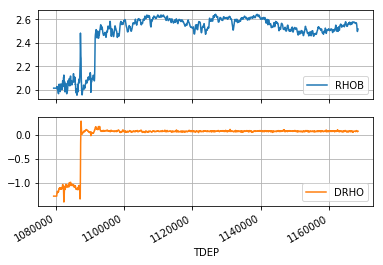

In [21]:
df.plot(kind='line',subplots=True,grid=True, legend='reverse')

## Compound Arrays

### Now sometimes curve values will have an array for a value at a certain index number - this gets trickier to handle.  Petrel for example won't even recognize that these curves exist in the dlis file.  These are set up as compound arrays.  Curve SAZ1 below has several samples that are actually arrays.

In [23]:
print(curves_L[0].dtype.names[44])
curves_L[1][44]

UCVE


(1079808., 5624050., [ 839.7    ,  817.3    ,  735.0999 ,  749.30005,  943.8    , 1013.99994,  916.80005,  629.7    , 1013.9    ,  876.6    , 1085.8    , 1038.4    , 1007.5    ,  802.1    ,  878.8    ,  855.     ], [5085., 4920., 4721., 4606., 4696., 4563., 4535., 4776., 4923., 4802., 6249., 6403., 5887., 4991., 4907., 4827.], [273.5     , 290.4     , 242.      , 456.89996 , 250.1     ,  50.000004, 285.8     , 333.5     , 277.9     , 271.7     , 352.7     , 363.1     , 365.8     , 271.6     , 266.5     , 261.3     ], [ 73.800446,  92.02634 , 131.17795 , 117.50833 ,  81.56408 ,  34.987038, 236.6082  , 245.77301 , 248.18333 ,  46.66692 ,  51.438942,  49.173065,  64.32855 ,  66.562195,  70.23692 ,  65.47858 ], [1.858006 , 1.8709357, 1.511118 , 1.5304236, 2.9435747, 3.1492476, 3.0296018, 1.595834 , 1.6909161, 1.9294558, 2.0532522, 2.1249986, 2.0338652, 1.9264317, 1.8795341, 1.8957775], [3.2147589, 3.2343457, 3.1172793, 3.1543999, 4.070077 , 4.176561 , 4.107199 , 3.1566377, 3.168947 , 3.155

### So we convert everything to tuples, which allows the arrays to be values at index levels in a pandas dataframe.  We get the column names from the nparray.

In [24]:
converted_curves = tuple(curves_L[0])
curves_df = pd.DataFrame.from_records(converted_curves, columns=curves_L[0].dtype.names)

In [25]:
curves_df = curves_df.set_index("TDEP")
curves_df = curves_df.replace(-999.25,np.NaN)

In [26]:
curves_df.iloc[300:315]

,6TIM,ROP5_RM,RFSA,RFSB,RFSL,RFSU,RFSR,QC_SIGM,QC_SPEC,CHY_WALK2,...,BPHR_UNC,DBPHI,DBPHB,DBPHL,DBPHU,DBPHR,QC_BPHI,QC_TNPH,TAB_NEU,MONT
TDEP,,,,,,,,,,,,,,,,,,,,,
1097280.0,6770950.0,13.434171,15.399333,15.061997,15.632330,15.782668,15.109667,0.0,0.615685,4.386765,...,10.774198,-0.572538,-0.336611,-0.561039,-1.054425,-0.364254,0.0,0.0,10668.0,4815.555664
1097340.0,6773750.0,13.220645,15.218158,15.051053,15.474738,15.261841,15.076578,0.0,0.575362,4.446764,...,10.355131,-0.462618,-0.136253,-0.606229,-0.850895,-0.329771,0.0,0.0,10666.0,4789.315918
1097400.0,6776650.0,12.700258,15.221177,15.155293,15.622941,15.497941,14.570881,0.0,0.622660,4.528908,...,11.848033,-0.332250,-0.181782,-0.545450,-0.567075,-0.084603,0.0,0.0,10636.0,4820.368652
1097460.0,6779550.0,12.192106,15.242498,15.157000,15.105501,15.136749,15.637500,0.0,0.583244,4.501635,...,11.285124,-0.481719,-0.256874,-0.524735,-0.810129,-0.318770,0.0,0.0,10614.0,4841.818359
1097520.0,6782250.0,11.422690,15.168332,15.183333,14.754764,15.640475,14.940954,0.0,0.555677,4.547090,...,11.304980,-0.443532,-0.113593,-0.569027,-0.961535,-0.387856,0.0,0.0,10596.0,4838.545410
1097580.0,6785050.0,11.197069,15.395453,16.124771,14.917500,15.350226,15.218408,0.0,0.552570,4.678182,...,11.650233,-0.363324,-0.197286,-0.447209,-0.803818,-0.361368,0.0,0.0,10578.0,4819.454590
1097640.0,6787750.0,10.800249,15.552047,15.352045,15.899317,15.735681,15.486362,0.0,0.532188,4.808658,...,12.331393,-0.475158,-0.235489,-0.679777,-0.889946,-0.393653,0.0,0.0,10564.0,4843.333496
1097700.0,6790150.0,10.430534,15.748810,16.072620,15.828808,15.944524,15.563809,0.0,0.526438,5.151515,...,12.454732,-0.455309,-0.329137,-0.664008,-0.780695,-0.365902,0.0,0.0,10558.0,4803.047852
1097760.0,6792450.0,10.254999,15.636665,15.166665,15.461667,15.897858,16.094286,0.0,0.519400,5.264503,...,12.965643,-0.217563,-0.053676,-0.448555,-0.616430,-0.264848,0.0,0.0,10556.0,4844.272949


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001940B3C8>,
      dtype=object)

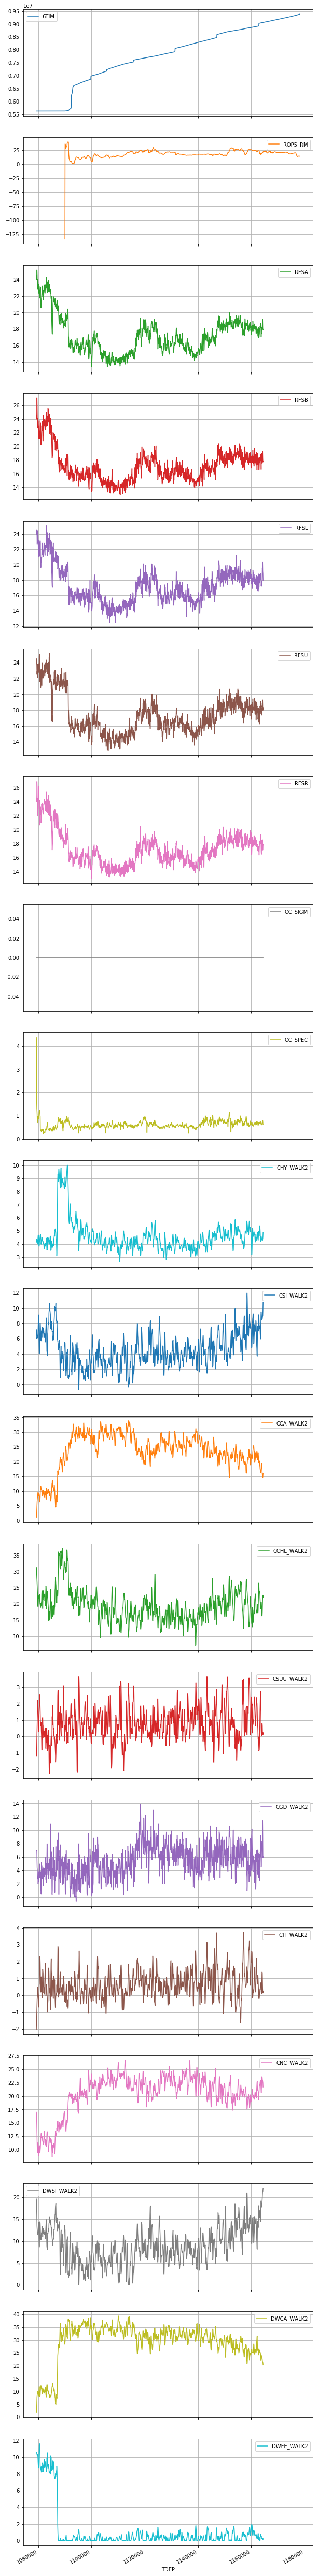

In [27]:
curves_df.iloc[:,0:20].plot(kind='line',subplots=True, figsize=(10,100),grid=True, legend='reverse')

### We can use the value_counts method to see how many curves actually represent multiple values per sample:

In [28]:
curves_df.dtypes.value_counts()

float64    249
object      13
dtype: int64

### And find their names and data:

In [29]:
curves_df.select_dtypes(['object']).iloc[300:315]

,USOI_FILT,SAZ1,SAZ2,LSAZ,RLSC,RSSC,ROSC,DRSC,PESC,USC,DCRA,GR_IMG16_FILT,GRIQ_FILT
TDEP,,,,,,,,,,,,,
1097280.0,"[0.53, 0.51, 0.4525, 0.38, 0.2940909, 0.209375...","[3295.4238, 3374.4683, 3589.86, 3658.4297, 386...","[14554.1, 14438.78, 14251.309, 14028.271, 1374...","[842.85547, 856.9036, 837.7236, 795.332, 769.4...","[2.3994446, 2.4194016, 2.4440095, 2.480591, 2....","[2.0910063, 2.144009, 2.2396548, 2.3191612, 2....","[2.556242, 2.5570104, 2.545327, 2.5615299, 2.5...","[0.15679748, 0.13760866, 0.10131735, 0.0809387...","[10.397745, 9.89282, 8.600036, 7.650196, 6.729...","[26.660172, 25.37263, 21.963087, 19.653154, 17...","[4.423388, 4.379425, 4.331577, 4.2767653, 4.23...","[9.536002, 9.409264, 7.555776, 7.2322173, 6.96...","[7.348528, 6.679862, 6.011196, 5.34253, 4.6738..."
1097340.0,"[0.5263636, 0.50272727, 0.44886363, 0.38, 0.29...","[3360.6492, 3354.2742, 3563.0613, 3689.5671, 3...","[14547.954, 14351.235, 14135.549, 13827.698, 1...","[884.92694, 846.1345, 821.14874, 778.09534, 77...","[2.3983958, 2.4141572, 2.445146, 2.4789848, 2....","[2.0979373, 2.152089, 2.2271023, 2.3068113, 2....","[2.5503724, 2.5445375, 2.5531113, 2.5649881, 2...","[0.15197663, 0.13038053, 0.10796519, 0.0860032...","[10.427823, 10.017384, 8.680691, 7.733137, 6.5...","[26.68011, 25.575377, 22.232197, 19.891212, 16...","[4.4171076, 4.382252, 4.3233685, 4.2754173, 4....","[9.825423, 8.36455, 6.76149, 5.6522174, 6.1361...","[8.64206, 8.193565, 7.745071, 7.2965765, 6.848..."
1097400.0,"[0.53, 0.5119047, 0.4563095, 0.38190475, 0.298...","[3332.79, 3344.6055, 3467.4878, 3647.2014, 388...","[14407.312, 14119.822, 14041.766, 13854.651, 1...","[877.5244, 854.16187, 825.9848, 814.037, 776.8...","[2.386118, 2.4040914, 2.4429293, 2.4714222, 2....","[2.0985153, 2.133679, 2.2126868, 2.3173466, 2....","[2.5305882, 2.5389686, 2.5569239, 2.5488966, 2...","[0.14447029, 0.13487732, 0.11399458, 0.0774743...","[10.4737215, 10.197995, 8.815354, 7.5482745, 6...","[26.60396, 25.983437, 22.608484, 19.302233, 16...","[4.4059405, 4.3654747, 4.290248, 4.2645674, 4....","[9.603684, 6.687158, 7.236273, 7.4809127, 6.03...","[7.2714977, 6.208629, 5.1457605, 4.082892, 3.0..."
1097460.0,"[0.53, 0.51238096, 0.4572619, 0.38238096, 0.29...","[3306.7683, 3337.4202, 3539.822, 3786.714, 397...","[14546.029, 14630.545, 14395.319, 13970.912, 1...","[897.7772, 892.6983, 840.53577, 834.6969, 829....","[2.3888988, 2.389186, 2.427434, 2.449293, 2.47...","[2.0949588, 2.1169693, 2.1986158, 2.2970223, 2...","[2.5370314, 2.5250485, 2.5407188, 2.5259166, 2...","[0.14813238, 0.13586253, 0.11328473, 0.0766236...","[10.452647, 10.202786, 8.962031, 7.649421, 6.5...","[26.613346, 25.862963, 22.848982, 19.396662, 1...","[4.395957, 4.3953214, 4.3181343, 4.2827826, 4....","[8.906866, 7.070339, 6.1717277, 6.2250037, 5.7...","[5.171355, 5.6280146, 6.084675, 6.541335, 6.99..."
1097520.0,"[0.53, 0.5209091, 0.47431815, 0.39090908, 0.29...","[3368.5967, 3420.1023, 3542.3865, 3718.5144, 3...","[14603.485, 14610.201, 14285.276, 14084.006, 1...","[872.5161, 913.1295, 881.45386, 866.5713, 864....","[2.385045, 2.3836577, 2.4191046, 2.4327214, 2....","[2.07556, 2.0820494, 2.1823668, 2.2810194, 2.3...","[2.5424848, 2.5363212, 2.5363593, 2.5090768, 2...","[0.15743965, 0.15266329, 0.11725454, 0.0763555...","[10.443293, 10.24941, 8.883635, 7.6211514, 6.6...","[26.642736, 26.089087, 22.612928, 19.20508, 16...","[4.3995514, 4.402695, 4.3279443, 4.295269, 4.2...","[6.637295, 6.6550536, 5.980299, 6.9658732, 7.3...","[7.62741, 7.328165, 7.0289207, 6.7296762, 6.43..."
1097580.0,"[0.53, 0.5281818, 0.48886362, 0.3981818, 0.305...","[3377.0774, 3389.683, 3566.9343, 3744.5718, 39...","[14694.802, 14605.524, 14319.384, 14106.161, 1...","[893.9769, 874.5844, 865.4166, 887.18646, 816....","[2.3877556, 2.3744357, 2.4102228, 2.4249697, 2...","[2.0632997, 2.0834033, 2.1873798, 2.2767823, 2...","[2.5546472, 2.520879, 2.5205467, 2.4996686, 2....","[0.16689175, 0.14644316, 0.11032385, 0.0746986...","[10.266833, 10.166724, 8.819579, 7.618988

### Taking another look at cuve SAZ1, we can see that it has arrays for each index and its type is an object.

In [30]:
curve_reindexed.loc[['SAZ1']]

,Curve,Long,Unit,Internal_File,Dup
Curve_Name,,,,,
SAZ1,SAZ1,"Raw Short Spacing Window 1 Count Rate, 16-Sect...",1/s,1,False


In [31]:
curves_df.SAZ1.iloc[0:10]

TDEP
1079280.0    [839.7, 817.3, 735.0999, 749.30005, 943.8, 101...
1079340.0    [839.7, 817.3, 735.0999, 749.30005, 943.8, 101...
1079400.0    [839.7, 817.3, 735.0999, 749.30005, 943.8, 101...
1079460.0    [839.7, 817.3, 735.0999, 749.30005, 943.8, 101...
1079520.0    [839.7, 817.3, 735.0999, 749.30005, 943.8, 101...
1079580.0    [839.7, 817.3, 735.0999, 749.30005, 943.8, 101...
1079640.0    [839.7, 817.3, 735.0999, 749.30005, 943.8, 101...
1079700.0    [839.7, 817.3, 735.0999, 749.30005, 943.8, 101...
1079760.0    [839.7, 817.3, 735.0999, 749.30005, 943.8, 101...
1079820.0    [839.7, 817.3, 735.0999, 749.30005, 943.8, 101...
Name: SAZ1, dtype: object

### You can always expand out the values into their own columns using the apply method below:

In [ ]:
curves_df['SAZ1'].apply(pd.Series).iloc[300:315]

# Hopefully that is enough code to get you started working with DLISIO.  There is much more functionality which can be accessed with help(dlisio)